In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import cv2

# DATA GENERATOR

In [2]:
TRAIN_DIR = "/kaggle/input/pain-face-fellows/pain face fellows v3/dataset/training"
VAL_DIR = "/kaggle/input/pain-face-fellows/pain face fellows v3/dataset/validation"

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1.2,
    rotation_range= 10, #-10 degree - 10 degree
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range=[0.4,1.5],
    zoom_range=0.2
    
)
batch_size = 64

train_generator = data_generator.flow_from_directory(
    directory= TRAIN_DIR,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True,
    seed=42
)



validation_generator= data_generator.flow_from_directory(
    directory= VAL_DIR,
    target_size=(128, 128),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False,
    seed=42
)

train_generator.samples, validation_generator.samples

Found 146 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


(146, 41)

# CLASS WEIGHT

In [5]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(train_generator.classes),class_weight.compute_class_weight(
                        class_weight = 'balanced',
                        classes = np.unique(train_generator.classes), 
                        y = train_generator.classes)))

# Helper Functions

In [6]:
def plot_history(hist):
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc='upper left')
    plt.show()

# Building Model

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras import applications
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.applications import xception

In [8]:
def Model_vgg(img_shape, fine_tune=0):
    pretrained_model = applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=img_shape)
    model = Sequential()
    
    for layer in pretrained_model.layers:
        model.add(layer)
    
    # freezing vgg16 layers
    if fine_tune > 0:
        for layer in model.layers[:-fine_tune]:
            layer.trainable = False
    elif fine_tune == 'all':
        pass
    else:
        for layer in model.layers:
            layer.trainable = False
    # building dense layer
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(500,activation='relu'))
    model.add(Dropout(0.8))
#     model.add(Dense(500, activation='relu'))
#     model.add(Dropout(0.6))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

# Setting Callback

In [9]:
# creating logs
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


LOG_NAME = "logs/vgg16_1"
# !mkdir "logs/"
tensorboard = TensorBoard(log_dir=LOG_NAME)

# checkpoints
CHECKPOINT_NAME = "checkpoints/checkpoint_e{epoch:02d}_acc_{accuracy:.02f}_Va{val_accuracy:.02f}.h5"
checkpoint = ModelCheckpoint(CHECKPOINT_NAME, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                            mode='max')

2022-12-21 00:53:54.294111: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-21 00:53:54.294149: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-21 00:53:54.399120: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-12-21 00:53:54.437490: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-21 00:53:54.437653: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


# Model Training

In [11]:
model = Model_vgg((128, 128, 3))

2022-12-21 00:54:48.791530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 00:54:48.797090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 00:54:48.943932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 00:54:48.944973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 00:54:48.945872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

58900480/58889256 [==============================] - 0s 0us/step


2022-12-21 00:54:56.499839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2


2022-12-21 00:54:59.546413: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/3 [=========>....................] - ETA: 22s - loss: 2.6463 - accuracy: 0.6111

2022-12-21 00:55:07.747336: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-21 00:55:07.747373: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/3 [===================>..........] - ETA: 5s - loss: 2.2269 - accuracy: 0.5976 

2022-12-21 00:55:12.749793: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-21 00:55:12.752204: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-21 00:55:12.910487: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2871 callback api events and 2390 activity events. 
2022-12-21 00:55:12.940844: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/3 [==============================] - ETA: 0s - loss: 2.0245 - accuracy: 0.5685

2022-12-21 00:55:12.999870: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_21_00_55_12

2022-12-21 00:55:13.031670: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_21_00_55_12/405d7b505796.trace.json.gz
2022-12-21 00:55:13.070889: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_21_00_55_12

2022-12-21 00:55:13.074427: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_21_00_55_12/405d7b505796.memory_profile.json.gz
2022-12-21 00:55:13.075552: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_21_00_55_12
Dumped tool data for xplane.pb to logs/vgg16_1/train/plugins/

3/3 [==============================] - 21s 5s/step - loss: 2.0245 - accuracy: 0.5685 - val_loss: 14.4435 - val_accuracy: 0.4390

Epoch 00001: val_accuracy improved from -inf to 0.43902, saving model to checkpoints/checkpoint_e01_acc_0.57_Va0.44.h5
Epoch 2/2
3/3 [==============================] - 2s 572ms/step - loss: 2.2765 - accuracy: 0.5685 - val_loss: 15.1274 - val_accuracy: 0.4390

Epoch 00002: val_accuracy did not improve from 0.43902


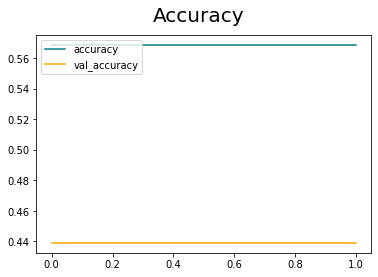

In [12]:
hist = model.fit(train_generator,
                steps_per_epoch = train_generator.samples // batch_size + 1,
                validation_data = validation_generator,
                validation_steps = validation_generator.samples // batch_size + 1,
                verbose = 1,
                epochs = 2,
                callbacks=[tensorboard, checkpoint],
                class_weight=class_weights)

plot_history(hist)

In [15]:
for k,v in hist.history.items():
    print(k,v)

loss [2.0245344638824463, 2.2765071392059326]
accuracy [0.568493127822876, 0.568493127822876]
val_loss [14.443524360656738, 15.127426147460938]
val_accuracy [0.4390243887901306, 0.4390243887901306]


Epoch 1/50
1/2 [==============>...............] - ETA: 0s - loss: 0.7775 - accuracy: 0.6774

2022-12-20 06:02:34.566141: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-20 06:02:34.566185: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/2 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.7302

2022-12-20 06:02:35.119473: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-20 06:02:35.119900: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-20 06:02:35.272225: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 186 callback api events and 183 activity events. 
2022-12-20 06:02:35.279006: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-20 06:02:35.285443: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_20_06_02_35

2022-12-20 06:02:35.289907: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_20_06_02_35/3033e1dad95e.trace.json.gz
2022-12-20 06:02:35.299210: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory:

2/2 [==============================] - 2s 1s/step - loss: 0.6767 - accuracy: 0.7302 - val_loss: 1.0035 - val_accuracy: 0.5000

Epoch 00001: val_accuracy did not improve from 0.75000
Epoch 2/50
2/2 [==============================] - 1s 596ms/step - loss: 1.1010 - accuracy: 0.6825 - val_loss: 1.2392 - val_accuracy: 0.5000

Epoch 00002: val_accuracy did not improve from 0.75000
Epoch 3/50
2/2 [==============================] - 1s 591ms/step - loss: 0.9935 - accuracy: 0.6270 - val_loss: 1.1723 - val_accuracy: 0.5500

Epoch 00003: val_accuracy did not improve from 0.75000
Epoch 4/50
2/2 [==============================] - 1s 783ms/step - loss: 0.9466 - accuracy: 0.6587 - val_loss: 0.7518 - val_accuracy: 0.5500

Epoch 00004: val_accuracy did not improve from 0.75000
Epoch 5/50
2/2 [==============================] - 1s 587ms/step - loss: 1.2570 - accuracy: 0.5952 - val_loss: 0.5975 - val_accuracy: 0.6000

Epoch 00005: val_accuracy did not improve from 0.75000
Epoch 6/50
2/2 [==================

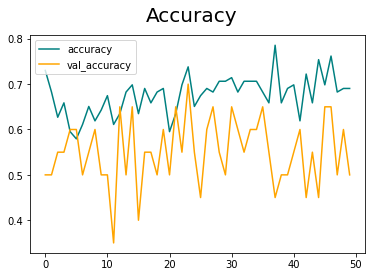

In [27]:
hist = model.fit(train_generator,
                steps_per_epoch = train_generator.samples // batch_size + 1,
                validation_data = validation_generator,
                validation_steps = validation_generator.samples // batch_size + 1,
                verbose = 1,
                epochs = 50,
                callbacks=[tensorboard, checkpoint],
                class_weight=class_weights)
plot_history(hist)

# Using VGGFace2 Pretrained Model

In [13]:
!pip install git+https://github.com/yaledhlab/vggface.git -q
!pip show keras_vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /opt/conda/lib/python3.7/site-packages
Requires: h5py, keras, numpy, pillow, pyyaml, scipy, six
Required-by: 


In [14]:
!pip install keras_applications -q

In [32]:
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1.2,
    rotation_range= 15, #-10 degree - 10 degree
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range=[0.4,1.5],
    zoom_range=0.2
    
)

batch_size = 40

train_generator = data_generator.flow_from_directory(
    directory= TRAIN_DIR,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True,
    seed=42
)



validation_generator= data_generator.flow_from_directory(
    directory= VAL_DIR,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False,
    seed=42
)

train_generator.samples, validation_generator.samples

Found 146 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


(146, 41)

In [36]:
from keras_vggface.vggface import VGGFace

def VGGFace_Custome(model_n="resnet50", fine_tune=0):
    vggface = VGGFace(model=model_n, include_top=False, input_shape=(224, 224, 3), pooling='avg')
    model = Sequential()

    model.add(vggface)
    
    # freezing vgg16 layers
    if fine_tune > 0:
        for layer in model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model.layers:
            layer.trainable = False
    
    # building dense layer
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.6))
    
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(2,activation='softmax'))
    
#     lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10,
#     decay_rate=0.1)

#     opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    
    model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    return model



In [37]:
vggface_model = VGGFace_Custome()

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/25
1/3 [=========>....................] - ETA: 1s - loss: 0.4364 - accuracy: 0.9000

2022-12-20 09:20:42.025526: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-20 09:20:42.026295: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/3 [===================>..........] - ETA: 0s - loss: 0.3242 - accuracy: 0.9125

2022-12-20 09:20:43.112963: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-20 09:20:43.114002: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-20 09:20:43.293260: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 363 callback api events and 360 activity events. 
2022-12-20 09:20:43.310686: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-20 09:20:43.331535: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_20_09_20_43

2022-12-20 09:20:43.342198: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_20_09_20_43/3d0ef650bd6d.trace.json.gz
2022-12-20 09:20:43.390632: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory:

3/3 [==============================] - 4s 2s/step - loss: 0.3583 - accuracy: 0.9057 - val_loss: 0.6158 - val_accuracy: 0.6500

Epoch 00001: val_accuracy did not improve from 0.85000
Epoch 2/25
3/3 [==============================] - 3s 1s/step - loss: 0.3053 - accuracy: 0.8750 - val_loss: 0.5340 - val_accuracy: 0.7000

Epoch 00002: val_accuracy did not improve from 0.85000
Epoch 3/25
3/3 [==============================] - 3s 1s/step - loss: 0.3232 - accuracy: 0.8774 - val_loss: 0.5621 - val_accuracy: 0.7000

Epoch 00003: val_accuracy did not improve from 0.85000
Epoch 4/25
3/3 [==============================] - 3s 1s/step - loss: 0.2135 - accuracy: 0.9340 - val_loss: 0.6413 - val_accuracy: 0.7000

Epoch 00004: val_accuracy did not improve from 0.85000
Epoch 5/25
3/3 [==============================] - 3s 1s/step - loss: 0.4092 - accuracy: 0.8868 - val_loss: 0.5872 - val_accuracy: 0.6750

Epoch 00005: val_accuracy did not improve from 0.85000
Epoch 6/25
3/3 [==============================

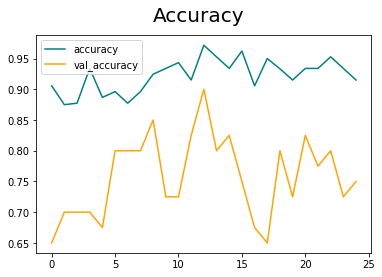

In [44]:
hist = vggface_model.fit(train_generator,
                steps_per_epoch = train_generator.samples // batch_size ,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // batch_size ,
                verbose = 1,
                epochs = 25,
                callbacks=[tensorboard, checkpoint],
#                 class_weight=class_weights
                )
plot_history(hist)

Epoch 1/15
1/5 [=====>........................] - ETA: 2s - loss: 0.4260 - accuracy: 0.7188

2022-12-20 08:45:28.862038: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-20 08:45:28.862400: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/5 [===========>..................] - ETA: 1s - loss: 0.4288 - accuracy: 0.7273

2022-12-20 08:45:29.242532: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-20 08:45:29.243152: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-20 08:45:29.420938: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 364 callback api events and 361 activity events. 
2022-12-20 08:45:29.437382: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


3/5 [=================>............] - ETA: 0s - loss: 0.4322 - accuracy: 0.6923

2022-12-20 08:45:29.456049: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_20_08_45_29

2022-12-20 08:45:29.466175: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_20_08_45_29/afd87b3f4b39.trace.json.gz
2022-12-20 08:45:29.517199: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_20_08_45_29

2022-12-20 08:45:29.525541: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_20_08_45_29/afd87b3f4b39.memory_profile.json.gz
2022-12-20 08:45:29.526828: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_20_08_45_29
Dumped tool data for xplane.pb to logs/vgg16_1/train/plugins/

5/5 [==============================] - 4s 764ms/step - loss: 0.4013 - accuracy: 0.7597 - val_loss: 0.9594 - val_accuracy: 0.5385

Epoch 00001: val_accuracy did not improve from 0.84615
Epoch 2/15
5/5 [==============================] - 3s 626ms/step - loss: 0.3949 - accuracy: 0.7752 - val_loss: 0.5940 - val_accuracy: 0.7949

Epoch 00002: val_accuracy did not improve from 0.84615
Epoch 3/15
5/5 [==============================] - 3s 517ms/step - loss: 0.3611 - accuracy: 0.7752 - val_loss: 0.8386 - val_accuracy: 0.7179

Epoch 00003: val_accuracy did not improve from 0.84615
Epoch 4/15
5/5 [==============================] - 3s 496ms/step - loss: 0.4785 - accuracy: 0.7364 - val_loss: 0.5425 - val_accuracy: 0.7692

Epoch 00004: val_accuracy did not improve from 0.84615
Epoch 5/15
5/5 [==============================] - 3s 498ms/step - loss: 0.3964 - accuracy: 0.7984 - val_loss: 0.7032 - val_accuracy: 0.6667

Epoch 00005: val_accuracy did not improve from 0.84615
Epoch 6/15
5/5 [===============

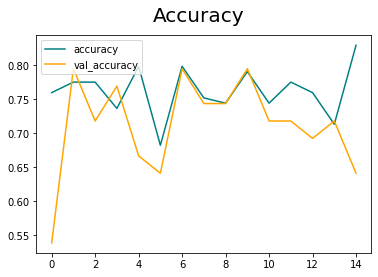

In [18]:
hist = vggface_model.fit(train_generator,
                steps_per_epoch = train_generator.samples // batch_size + 1,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // batch_size + 1,
                verbose = 1,
                epochs = 15,
                callbacks=[tensorboard, checkpoint],
                class_weight=class_weights)
plot_history(hist)

# Model Evaluation

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

In [64]:
evalu = vggface_model.evaluate(validation_generator)
print(vggface_model.metrics_names)
print(evalu)

2/2 [==============================] - 1s 20ms/step - loss: 0.3521 - accuracy: 0.8537
['loss', 'accuracy']
[0.3520660400390625, 0.8536585569381714]


In [65]:
Y_pred = vggface_model.predict_generator(validation_generator, validation_generator.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix: ')
confusion_matrix_ = confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix_)

print('Classification Report')
target_names = ['0', '1']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix: 
[[17  1]
 [ 4 19]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        18
           1       0.95      0.83      0.88        23

    accuracy                           0.88        41
   macro avg       0.88      0.89      0.88        41
weighted avg       0.89      0.88      0.88        41



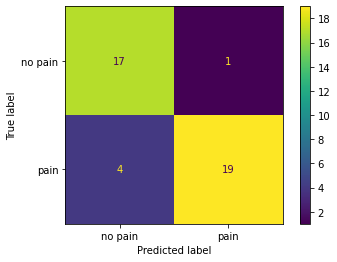

<Figure size 432x288 with 0 Axes>

In [66]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_, display_labels = ['no pain', 'pain'])
cm_display.plot()
plt.show()
plt.savefig("confusion matrix")

#  Fine Tunning

In [48]:
vggface_model.trainable  = True
assert vggface_model.layers[0].trainable == True
vggface_model.layers[0]

Epoch 1/50
1/4 [======>.......................] - ETA: 2s - loss: 0.0483 - accuracy: 1.0000

2022-12-20 09:30:17.561255: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-20 09:30:17.561307: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


2/4 [==============>...............] - ETA: 1s - loss: 0.0371 - accuracy: 1.0000

2022-12-20 09:30:18.288959: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-20 09:30:18.289743: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-20 09:30:18.488105: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 367 callback api events and 364 activity events. 
2022-12-20 09:30:18.506060: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-20 09:30:18.526046: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_20_09_30_18

2022-12-20 09:30:18.536606: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_20_09_30_18/3d0ef650bd6d.trace.json.gz
2022-12-20 09:30:18.597767: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory:

4/4 [==============================] - 4s 1s/step - loss: 0.0493 - accuracy: 0.9795 - val_loss: 1.3320 - val_accuracy: 0.7561

Epoch 00001: val_accuracy did not improve from 0.90000
Epoch 2/50
4/4 [==============================] - 3s 757ms/step - loss: 0.0404 - accuracy: 0.9795 - val_loss: 1.1056 - val_accuracy: 0.7805

Epoch 00002: val_accuracy did not improve from 0.90000
Epoch 3/50
4/4 [==============================] - 3s 780ms/step - loss: 0.0454 - accuracy: 0.9932 - val_loss: 1.2658 - val_accuracy: 0.7317

Epoch 00003: val_accuracy did not improve from 0.90000
Epoch 4/50
4/4 [==============================] - 4s 1s/step - loss: 0.0463 - accuracy: 0.9863 - val_loss: 1.2409 - val_accuracy: 0.7561

Epoch 00004: val_accuracy did not improve from 0.90000
Epoch 5/50
4/4 [==============================] - 3s 753ms/step - loss: 0.0736 - accuracy: 0.9589 - val_loss: 0.9676 - val_accuracy: 0.8293

Epoch 00005: val_accuracy did not improve from 0.90000
Epoch 6/50
4/4 [=====================

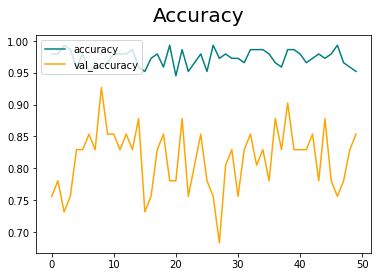

In [51]:
hist = vggface_model.fit(train_generator,
                steps_per_epoch = train_generator.samples // batch_size + 1,
                validation_data = validation_generator, 
                validation_steps = validation_generator.samples // batch_size + 1, 
                verbose = 1,
                epochs = 50,
                callbacks=[tensorboard, checkpoint],
                class_weight=class_weights)
plot_history(hist)

# Download Checkpoints

In [52]:
!zip -r file_checkpoints.zip /kaggle/working/checkpoints

updating: kaggle/working/checkpoints/ (stored 0%)
updating: kaggle/working/checkpoints/checkpoint_e04_Va0.59.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e02_Va0.77.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e01_Va0.54.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e01_Va0.75.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e04_Va0.85.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e02_Va0.56.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e13_Va0.90.h5 (deflated 7%)
  adding: kaggle/working/checkpoints/checkpoint_e09_Va0.93.h5 (deflated 7%)


In [53]:
vggface_model.save("vggface_acc_95_val_acc_85.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# prediction

In [54]:
!wget "https://media.istockphoto.com/id/1273195457/photo/dealing-with-a-bit-of-tension.jpg?s=612x612&w=0&k=20&c=QSsovLTPUMwOOlnDSSPIGSgz9ZPeTF6SaFV-foKmdSg="

--2022-12-20 09:37:39--  https://media.istockphoto.com/id/1273195457/photo/dealing-with-a-bit-of-tension.jpg?s=612x612&w=0&k=20&c=QSsovLTPUMwOOlnDSSPIGSgz9ZPeTF6SaFV-foKmdSg=
Resolving media.istockphoto.com (media.istockphoto.com)... 18.165.116.109, 18.165.116.39, 18.165.116.17, ...
Connecting to media.istockphoto.com (media.istockphoto.com)|18.165.116.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30141 (29K) [image/jpeg]
Saving to: ‘dealing-with-a-bit-of-tension.jpg?s=612x612&w=0&k=20&c=QSsovLTPUMwOOlnDSSPIGSgz9ZPeTF6SaFV-foKmdSg=’

dealing-with-a-bit- 100%[===================>]  29.43K  --.-KB/s    in 0.003s  

2022-12-20 09:37:40 (9.38 MB/s) - ‘dealing-with-a-bit-of-tension.jpg?s=612x612&w=0&k=20&c=QSsovLTPUMwOOlnDSSPIGSgz9ZPeTF6SaFV-foKmdSg=’ saved [30141/30141]



In [57]:
# !pip install dlib

In [60]:
import dlib

def predict(image, model, image_shape=224):
    IMG_SHAPE = image_shape
    
    # detect face in the image
    face_detector = dlib.get_frontal_face_detector()
    faces = face_detector(image, 1)
                
    if not len(faces):
        c += 1
        print("no face detected..")
        return -1
                    
    face = faces[0]
    x = face.left()
    y = face.top()
    x1 = face.right()
    y1 = face.bottom()

    face_cropped = image[y: y1, x: x1]
    img_data = cv2.resize(face_cropped, (IMG_SHAPE, IMG_SHAPE))
    return np.argmax(model.predict(img_data.reshape(-1, IMG_SHAPE, IMG_SHAPE, 3)), axis=1)

In [61]:
image = cv2.imread("/kaggle/working/dealing-with-a-bit-of-tension.jpg?s=612x612&w=0&k=20&c=QSsovLTPUMwOOlnDSSPIGSgz9ZPeTF6SaFV-foKmdSg=")
predict(image, vggface_model)

array([1])

In [62]:
!wget "https://chopra.brightspotcdn.com/b5/41/8aebe23d84a88f9a0a56b9924c37/guylaughing.jpg"

--2022-12-20 09:43:17--  https://chopra.brightspotcdn.com/b5/41/8aebe23d84a88f9a0a56b9924c37/guylaughing.jpg
Resolving chopra.brightspotcdn.com (chopra.brightspotcdn.com)... 13.33.4.120, 13.33.4.117, 13.33.4.14, ...
Connecting to chopra.brightspotcdn.com (chopra.brightspotcdn.com)|13.33.4.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50218 (49K) [image/jpeg]
Saving to: ‘guylaughing.jpg’

guylaughing.jpg     100%[===================>]  49.04K  --.-KB/s    in 0.04s   

2022-12-20 09:43:17 (1.25 MB/s) - ‘guylaughing.jpg’ saved [50218/50218]



In [63]:
image = cv2.imread("/kaggle/working/guylaughing.jpg")
predict(image, vggface_model)

array([0])